Readme

# Behavioral Cloning
This is a Udacity Self-Driving Car NanoDegree project submission that uses deep learning to clone driving behavior.

![](./wup_assets/mtn-turning.png)

## Installation
Clone or fork this repository. For dependencies, see `env-bcl-gpu.yml` for packages. Also requires
[Udacity's Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim).

## Usage
Intended user is the Udacity evaluator for this project. To view a video recording of the vehicle autonomously driving around a simulated mountainous track from the perspective of a camera mounted at the center of the vehicle, play the following mp4:

`video.mp4`

To directly observe the vehicle autonomously driving from a third person view, do the following:

1. Start the autonomous driver: `python drive.py model.h5`
2. Start Udacity's Self-Driving Car Simulator (SDCS), and click the play button.
3. Select track to drive on in the SDCS.
4. Select Autonomous Mode in the SDCS. This connects the simulator to `drive.py` which drives the car around the selected track based on the machine learning model captured in `model.h5`.

## Files
### Project Files
- `model.py`: Python script used to create and train the model.
- `drive.py`: Python script used to autonomously drive the car.
- `model.h5` : The saved model.
- `writeup_report.md`: writeup of project for Udacity evaluator.
- `video.mp4`: video recording of vehicle driving around track 2 in the opposite direction.

### Other files 
- Additional videos from 3rd person perspective:
  - `auto_easy_3p.mp4`: driving around track 1.
  - `auto_easy_rev_3p.mp4`: driving in opposite direction around track 1.
  - `auto_hard_3p.mp4`: driving around track 2.
  - `auto_hard_rev_3p.mp4`: driving in opposite direction around track 2.  
- Additional videos from driver perspective:
  - `auto_easy.mp4`: driving around track 1.
  - `auto_easy_rev.mp4`: driving in opposite direction around track 1.
  - `auto_hard.mp4`: driving around track 2.
- `env-bcl-gpu.yml`: YAML file for installing other packages in a Conda environment.
- `proto.ipynb`: Jupyter Notebook for prototyping python and markdown code.
- `training_log.csv`: CSV file showing training history of `model.h5`.
- `video.py`: Udacity included script for generating video of vehicle driving.
- `data_easy_route`: contains training data consisting of driving log and images of recording of vehicle driving around track_1
- `data_hard_route`: contains training data consisting of driving log and images of recording of vehicle driving around track_2

# writeup

12-MAR-2021
# Behavioral Cloning
This is a Udacity Self-Driving Car NanoDegree project submission that uses deep learning to clone driving behavior.

![](./wup_assets/mtn-turning.png)

## Table of Contents
- [**Required Files**](#required-files)
- [**Quality of Code**](#quality-of-code)
  - [Code Functionality](#code-functionality)
  - [Code Usability](#code-usability)
  - [Code Readability](#code-readability) 
- [**Model Architecture and Training Strategy**](#model-architecture-and-training-strategy)
  - [General Architecture Employed](#general-architecture-employed)
  - [Reducing Overfitting](#reducing-overfitting)
  - [Parameter Tuning](#parameter-tuning)
  - [Training Data Chosen](#training-data-chosen)
- [**Architecture and Training Documentation**](#architecture-and-training-documentation)  
  - [Solution Design Approach](#solution-design-approach)
  - [Final Model Architecture](#final-model-architecture)
  - [Training Data Set](#training-data-set)
- [**Simulation**](#Simulation)    

## Required Files
- `model.py`: Python script used to create and train the model.
- `drive.py`: Python script used to autonomously drive the car. This script has the following modifications:
  - Desired speed was increased to 30 mph from the original 9 mph.
  - Vehicle will slow down aggressively when initiating a turn, then returns to desired speed.
- `model.h5` : The saved model.
- `writeup_report.md`: writeup of project for Udacity evaluator.
- `video.mp4`: video recording of vehicle driving around track 2 in the opposite direction from the driver's perspective. Track 2 was chosen for the recording because there were more exciting turns. The third person perspective of this video can be viewed in `auto_hard_rev_3p.mp4`.

## Quality of Code

### Code Functionality

The model was trained with data from recording 2 laps of driving on track 1 (easy lakeside road) and track 2 (difficult mountainous road). The model was saved to `model.h5` and can be observed to successuly operate the simulation in track 1 and track 2 using the following:

`python drive.py model.h5`

### Code Usability 

The script to create the model is `model.py`. It uses a data generator class, `DrivingLogSequence`, that inherits from `keras.utils.Sequence`. This class accesses data from two folders, `data_easy_route` and `data_hard_route`, to generate images and steering angle data for training rather than storing the entire folders of images and steerings angles into memory.

The main function in `model.py` that creates the neural network is `create_model()`. The function `train_model()` then trains the model using `DrivingLogSequence` data generators and saves the model to the file `model.h5`

### Code Readability

The code follows [PEP-8](https://www.python.org/dev/peps/pep-0008/) Style Guide as much as possible and [PEP-257](https://www.python.org/dev/peps/pep-0257/) Docstring Conventions. For instance:

```python
# ...etc...
    def samples(self, camera, img, steering):
        '''
        Creates a list of image and steering data for 
        adding to a batch of samples. Used in __getitem__().
        
        Params
            camera: name of camera; 'center', 'left', or 'right'.
            img: rgb image of camera
            steering: steering ANGLE (float) applied
        '''
# ...etc...
```

["Snake case"](https://en.wikipedia.org/wiki/Snake_case) is predominantly used except for class names which use ["Camel Case"](https://en.wikipedia.org/wiki/Camel_case). For instance:

```python
# ...etc...
class DrivingLogSequence(Sequence):
    '''
    Generates driving log data for training. 
    Inherits from keras.utils.Sequence.
    Used in call to Model.fit_generator.
    
    '''

    def __init__ (self, driving_log, batch_size=16):
        '''
        Class initializer.
        
        Params:
            driving_log: a list of dicts containing the following keys:
                'center'   : filename to image from center camera
                'left'     : filename to image from left camera
                'right'    : filename to image from right camera
                'steering' : steering ANGLE applied
                
            batch_size: number of samples to get from driving log
        '''
        
        self.driving_log = driving_log
        self.batch_size = batch_size
        
        return
# ...etc...
```

## Model Architecture and Training Strategy

### General Architecture Employed

The model architecture is a linear stack of layers and is subclassed from `keras.Sequential`. It preprocesses the image with normalization and cropping, then employs convolution layers followed by several dense layers to output a steering angle.

### Reducing Overfitting

Rectified Linear Units served as the activation functions for each layer which was followed by dropout to reduce overfitting. Adding the non-linearities and dropout helped seemed to have the following effect:

- Decrease the final training loss from a mean squared error of around 0.06 to 0.02. 
- The model demonstrated an ability to generalize by driving in the opposite direction around both tracks using only training data of driving in the default direction.

### Parameter Tuning

The model uses an adam optimizer so a learning rate parameter was not chosen. This was sufficient in training the vechicle to drive on both track 1 and 2 succesffully. 

### Training Data Chosen

The training data was initially the default data provided by Udacity. However, the resulting model underperformed when driving on both tracks. Ultimately, default data provided by Udacity was discarded and replaced with data from the video recording of driving two laps around tracks 1 and 2 with their associated steering angles. The training data is contained in the following:

- `data_easy_route`: folder data from driving on track 1
  - `driving_log.csv`: comma separated value of image filenames and associated steering angles
  - `IMG`: folder containing images from center, left and right cameras of vehicles
- `data_hard_route`: folder containing images and driving log from track 2
  - `driving_log.csv`: comma separated value of image filenames and associated steering angles
  - `IMG`: folder containing images from center, left and right cameras of vehicles
  
## Architecture and Training Documentation

### Solution Design Approach

The approach to designing the model simply to recreate the model described in _"End-to-end Learning for Self-Driving Cars" by Bojarski et. al., 25APR2016_, then iteratively improve performance (lower training loss) by experimenting with the following:

- Adding activation function 
- Adding dropout 
- Initialy using default Udacity training dataset
- Augmenting default training dataset with manipulated camera images and steering inputs
- Creating own training datasets of track 1 and track 2 driving


### Final Model Architecture

After multiple iterations of modifying the model and training data, the final architecture is depicted below:

![](./wup_assets/cnn_architecture.png)

It is similar to _Bojarski et. al._'s model and has the following features:
- Preprocessing with normalization and cropping. Normalizing the image will help in finding the appropriate model weights and biases, and croppping the image removes unecessary data like the images of the surrounding landscape.
- Convolutional layers with `relu` activations (but same filter, kernel, and stride parameters as _Bojarski et. al._'s model).
- Extensive use of dropout after almost every layer except the last. Empirically, it seemed that using a low dropout rate of 0.1 or 0.2 helped in reducing overfitting than using a dropout value of 0.5 after the convolutions.

Below is a portion of the function `create_model()` which creates the final model:

```python
# ...etc...
model = Sequential()
model.add(Lambda(normalize, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=[(50, 20), (0, 0)]))

model.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.1))

model.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.1))

model.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='relu'))

model.add(Dense(1))
# ...etc...
```

###  Training Data Set

The default Udacity dataset was initially used which consisted of images from cameras mounted on the left, center and right of the vehicle, and a correspoding `steering_angle` for the center camera. 

To minimize use of memeory, a data generator, `DrivingLogSequence`, subclassed from `keras.utils.Sequence`, was used to fetch the images and steering_angle. 

The original images were flipped horizontally to provide additional data for driving in the opposite direction of the track. The corresponding steering angle for the flipped image is simply the negative of the original, `flipped_steering_angle = -steering_angle`.

![](./wup_assets/drv_udacity_data_image_1.png)

The images from the left and right cameras were also shifted further left or right respectively, to provide additional steering correction data. Through trial and error, a 50-pixel shift seemed suitable.

![](./wup_assets/drv_udacity_data_image_shift_right.png)
![](./wup_assets/drv_udacity_data_image_shift_left.png)

A angle of `0.35` seemed suitable and was applied to `steering_angle` for the left and right cameras (the correction angle was subtracted from the `steering_angle` for the right camera). 

```python
# correction ANGLEs for each camera
ANGLE       = 0.35
CORR_ANGLES = {'center': 0, 'left': ANGLE, 'right': -ANGLE}
```
The correction angle was applied again to the steering angle for the images that were shifted left and right.

Below is a portion of the code that, in the method `__getitem__()` reads the original image and `steering_angle` (with `CORR_ANGLES` applied), and then generates, in the method `samples()`, the shifted image and a shifted `steering_angle`.

```python
class DrivingLogSequence(Sequence):
    
# ...etc...

    def samples(self, camera, img, steering):
        '''
        Creates a list of image and steering data for 
        adding to a batch of samples. Used in __getitem__().
        
        Params
            camera: name of camera; 'center', 'left', or 'right'.
            img: rgb image of camera
            steering: steering ANGLE (float) applied        
        '''
        
        images    = []
        steerings = []
        
        # append base image
        images.append(img)
        steerings.append([steering])
        
        # if camera is left or right, augment data with image shifted
        # further left or right with additional steering correction
        if camera != 'center':
                # create shifted image and associated steering 
                shift_img       = shift(img, SHIFT_VALS[camera])
                shift_steering  = steering + CORR_ANGLES[camera]

                # append shifted image and associated steering
                images.append(shift_img)
                steerings.append([shift_steering])
                
        return images, steerings

    def __getitem__(self, index):
        '''
        Returns images and associated images from driving log during
        data generation.
        '''
        
        start = index
        end   = index + self.batch_size
        driving_log_batch = self.driving_log[start:end]
        
        X_images = []
        y_steerings = []
        
        for line in driving_log_batch:
            
            center_steering = float(line['steering'])
            
            for camera in CORR_ANGLES:
                
                img_filename = line[camera]
                
                img = plt.imread(img_filename)
                steering = center_steering + CORR_ANGLES[camera]
                
                images, steerings = self.samples(camera, img, steering)
                
                X_images.extend(images)
                y_steerings.extend(steerings)
            
        X = np.array(X_images)
        y = np.array(y_steerings)
        
        return X, y
    
# ...etc...
```

In the final training runs, flipping the image horizontally was discarded. This is because:

- It seemed to cause the vehicle to swerve left and right on straightaways. Removing the flipped image seemed to reduce the frequent left and right corrections on straightaways, especially on the bridges of track 1 and track 2.
- In track 2, after a tight right turn causes the vehicle to drift into the left lane, the vehicle did not correct back to the right lane until a tight left turn. This is likely because the flipped horizontal image on track 2 makes the vehicle appear to be in the left lane, and so it is trained that the left lane is a suitable lane for driving and will not correct back to the right. Removing the flipped image enabled the vehicle to correct back to the right lane on track 2 if at the end of a tight right turn the vehicle ended up on the left lane.

![](./wup_assets/drv_flipped_left_image.png)

The default Udacity dataset was discarded after the vehicle underperformed. Instead, it was replaced with training data generated from recording two laps of driving around tracks 1 and 2 (`data_easy_route` and `data_hard_route` respectively) in the default directions. Below is the history of the final training session that produced `model.h5`:

![](./wup_assets/history.png)

There was sufficient data that the model was able to generalize the training and successfully autonomously drive the vehicle in __both directions__ in both tracks, and in the case of track 2, maintain right lane driving or correct back to it.

## Simulation

`drive.py` was modified in the following ways:

- Desired speed was increased to 30 mph. The original speed of 9mph was agonizingly slow during test and evaluation.

- A simple cornering algorithm was used. Because the desired speed was increased to 30 mph, `drive.py` will aggressively slow down the vehicle when the steering angle is above a threshold value of 0.3, and will then attempt to maintain a turning speed of 23 mph throughout the turn. Once the turn is complete, it will resume the target speed of 30 mph.

- The class `RidgeRacerController`, subclassed from `SimplePIController`, was created to achieve the desired speed of 30 mph and slow down during turns. At no point does it modify the model predicted `steering_angle`.

```python
#  ...from drive.py:

class RidgeRacerController (SimplePIController):
    '''
    Controller for making vehicle go faster (30mph).
    With a higher speed, controller sets a more agressive throttle (Kp=2.0)
    and also adjusts speed when turning.
    '''
    def __init__(self):
        
        # Kp is 2.0 for more agressive throttle
        # either to brake or accelerate to target speed
        SimplePIController.__init__(self, Kp=2.0, Ki=0.002)
        
        # set RidgeRacer to target speed of 30 mph
        self.target_speed = 30
        self.turning = False
        self.prev_steering_angle = 0.0
        
        # steering angle threshold for commencing turn
        self.steering_angle_thresh = 0.3
        
        # speed to start braking if entering turn
        self.turn_speed = 23
        
        # speed to brake to when entering turn
        self.enter_turn_speed = 2.0
        
        # use a slow launch speed at start
        self.set_desired(0.3*self.target_speed)
        
    def adjust_speed (self, speed, steering_angle):
        '''
        Adjust vehicle speed to safely negotiate a turn.
        '''
    
        if not self.turning:
            if abs(steering_angle) > self.steering_angle_thresh:
                self.turning = True
                if speed > self.turn_speed:
                    # Entering Turn, slow down
                    self.set_desired(self.enter_turn_speed)
            else:
                # Going straight, setting target speed
                self.set_desired(self.target_speed)
        elif abs(steering_angle) > self.steering_angle_thresh:
            if self.set_point < self.turn_speed:
                # Still Turning, increasing to turn speed            
                self.set_desired(self.turn_speed)
        else:
            # Exiting turn, resume target speed        
            self.turning = False
            self.set_desired(self.target_speed)
            
        self.prev_steering_angle = steering_angle
        
        
# original controller spec:
# controller = SimplePIController(0.1, 0.002)

# use the RidgeRacer controller to go fast
controller = RidgeRacerController()

# ...etc...

```

Because the drive around the lake was boring, the video of the vehicle driving in the opposite direction around track 2 was used for the submission video, `video.mp4`. Additional videos of the vehicle driving autonomously around the track are as follows: 

- From 3rd person perspective:
  - `auto_easy_3p.mp4`: driving around track 1.
  - `auto_easy_rev_3p.mp4`: driving in opposite direction around track 1.
  - `auto_hard_3p.mp4`: driving around track 2.
  - `auto_hard_rev_3p.mp4`: driving in opposite direction around track 2.  
- From driver perspective:
  - `auto_easy.mp4`: driving around track 1.
  - `auto_easy_rev.mp4`: driving in opposite direction around track 1.
  - `auto_hard.mp4`: driving around track 2.

![](./wup_assets/drv_track_2_opp.png)






In [3]:
%load_ext tensorboard.notebook

ModuleNotFoundError: No module named 'tensorboard.notebook'

In [1]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [2]:


def create_model():
    '''
    Creates a model for use in autonmous driving mode. Architecture is 
    similar to the one in ref: Bojarski et. al., "End to end Larning 
    for Self-Driving Cars", 25APR2016.
    '''

    model = Sequential()
    model.add(Lambda(normalize, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=[(50, 20), (0, 0)]))
    
    model.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='relu'))
    
    model.add(Dense(1))    
    
    model.compile(loss='MSE', optimizer='Adam')
    
    return model

model = create_model()

model.load('model.h5')

NameError: name 'Sequential' is not defined

# Data Generator
---

In [1]:
from math import ceil, floor
from random import shuffle
from keras.utils import Sequence

import matplotlib.pyplot as plt
import csv
import numpy as np
from sklearn.model_selection import train_test_split


theta       = 0.35
corrections = {'center': 0, 'left': theta, 'right': -theta}

dx          = 50
shift_val   = {'left': dx, 'right': -dx}


def shift(img, dx):
        
    shifted_img = img.copy()
    if dx > 0:
        # shift right
        shifted_img[:,dx:] = img[:,:-dx]
    else:
        # shift left
        shifted_img[:,:dx] = img[:,-dx:]

    return shifted_img


# ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DrivingLogSequence(Sequence):
    
    def __init__ (self, driving_log, batch_size=32):
        
        self.driving_log = driving_log
        self.batch_size = batch_size
        
        return
    
    def __len__(self):
        return floor(len(self.driving_log)/self.batch_size)
    
    def add_data(self, img, steering):
        self.images.append(img)
        self.steerings.append([steering])
        return
    
    def __getitem__(self, index):
        
        batch_driving_log = self.driving_log[index:index+self.batch_size]
        self.images = []
        self.steerings = []
        
        for line in batch_driving_log:
            
            center_steering = float(line['steering'])
            
            for camera in corrections:
                
                filename = line[camera]
                
                img = plt.imread(filename).copy()
                steering = center_steering + corrections[camera]
                
                self.add_data(img,           steering)
                self.add_data(np.fliplr(img), -steering)
                
                if camera != 'center':
                    steering  = steering + corrections[camera]
                    shift_img = shift(img, shift_val[camera])
                    
                    self.add_data(shift_img,            steering)
                    self.add_data(np.fliplr(shift_img), -steering)
            
        X = np.array(self.images)
        y = np.array(self.steerings)
        
        return X, y
    
    def on_epoch_end(self):
        shuffle(self.driving_log)
        return
    

def create_generators(test_size=0.2, shuffle=True):
    
    drv_log_folders = ['data_easy_route','data_hard_route']
    drv_log_filename = 'driving_log.csv'

    drv_log = []
    for drv_log_folder in drv_log_folders:
        with open(drv_log_folder + '/' + drv_log_filename) as driving_log_file:
            driving_log_reader = csv.DictReader(driving_log_file)
            for line in driving_log_reader:
                for camera in corrections:
                    line[camera] = drv_log_folder + "/" + line[camera].strip()
                drv_log.append(line)
                
    training, validation = train_test_split(drv_log, test_size=0.2, shuffle=True)                                       
                       
    return DrivingLogSequence(training), DrivingLogSequence(validation)        
                       
                       
driving_log_seq_training, driving_log_seq_validation = create_generators()
                       

    

Using TensorFlow backend.


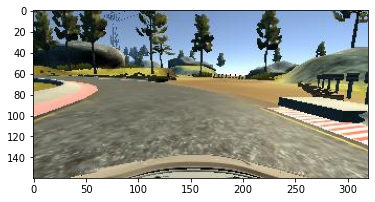

In [6]:
folder = 'C:\\Users\\Owner\\Documents\\git\\CarND-Behavioral-Cloning-P3\\etc\\data_easy_route_udacity\\IMG\\'
drv_img = 'center_2016_12_01_13_31_15_513.jpg'

img = plt.imread(folder + drv_img).copy()
plt.imshow(img)


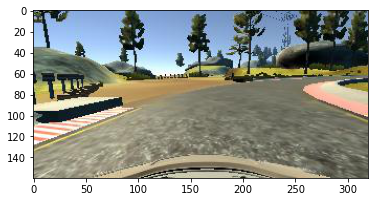

In [5]:
plt.imshow(np.fliplr(img))

Text(0.5, 1.0, 'Flipped')

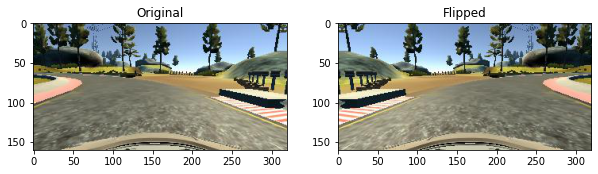

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(img)
ax2.imshow(np.fliplr(img))
ax1.set_title("Original")
ax2.set_title("Flipped")

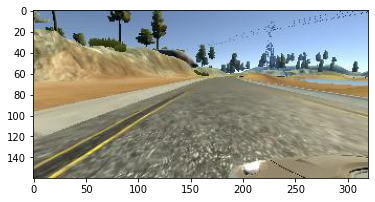

In [12]:
drv_img = 'left_2016_12_01_13_39_20_338.jpg'

img = plt.imread(folder + drv_img).copy()
plt.imshow(img)

Text(0.5, 1.0, 'Shifted Right')

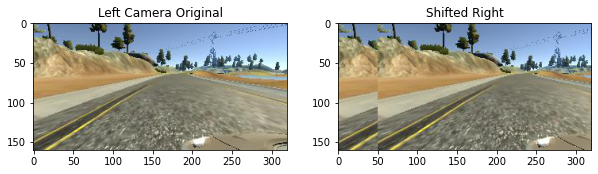

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(img)
ax2.imshow(shift(img, 50))
ax1.set_title("Left Camera Original")
ax2.set_title("Shifted Right")

Text(0.5, 1.0, 'Shifted Left')

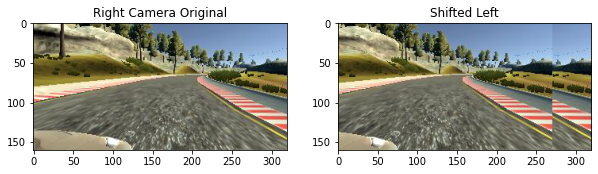

In [14]:
drv_img = 'right_2016_12_01_13_33_07_731.jpg'

img = plt.imread(folder + drv_img).copy()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(img)
ax2.imshow(shift(img, -50))
ax1.set_title("Right Camera Original")
ax2.set_title("Shifted Left")

Text(0.5, 1.0, 'Flipped - Car is in Left Lane')

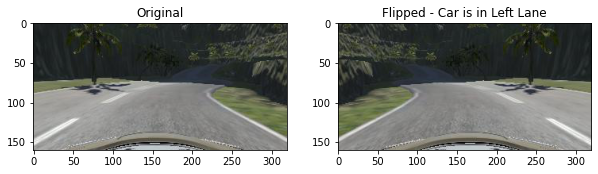

In [18]:
folder = 'C:\\Users\\Owner\\Documents\\git\\CarND-Behavioral-Cloning-P3\\data_hard_route\\IMG\\'
drv_img = 'center_2021_03_06_16_58_41_758.jpg'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(img)
ax2.imshow(np.fliplr(img))
ax1.set_title("Original")
ax2.set_title("Flipped - Car is in Left Lane")

In [ ]:
    def OLD__getitem__OLD(self, index):
        
        batch_driving_log = self.driving_log[index:index+self.batch_size]
        images = []
        steerings = []
        
        for line in batch_driving_log:
            
            center_steering = float(line['steering'])
            
            for cam_pos, theta in cameras:
                
                filename = line[cam_pos].strip()
                
                img = plt.imread(filename).copy()
                images.append(img)
                steering = center_steering + theta
                steerings.append([steering])
                
                # augment with flipped image
                flip_img = np.fliplr(img)
                images.append(flip_img)
                steerings.append([-steering])
                
                if cam_pos == 'left':
                    # augment with right shift
                    rightshift_img = shift(img, 50)
                    images.append(rightshift_img)
                    steerings.append([steering + theta])

                    # augment with flipped right shift image
                    flip_img = np.fliplr(rightshift_img)
                    images.append(flip_img)
                    steerings.append([-(steering + theta)])
                    
                elif cam_pos == 'right':
                    # augment with left shift
                    leftshift_img = shift(img, -50)
                    images.append(leftshift_img)
                    steerings.append([steering - theta])

                    # augment with flipped left shift image
                    flip_img = np.fliplr(leftshift_img)
                    images.append(flip_img)
                    steerings.append([-(steering - theta)])
            
        X = np.array(images)
        y = np.array(steerings)
        
        return X, y
    


In [ ]:
    
    
driving_log_filename = 

driving_log = []

with open(driving_log_filename) as driving_log_file:
    driving_log_reader = csv.DictReader(driving_log_file)
    for line in driving_log_reader:
        driving_log.append(line)
        
driving_log_filename = 'data/driving_log.csv'

with open(driving_log_filename) as driving_log_file:
    driving_log_reader = csv.DictReader(driving_log_file)
    for line in driving_log_reader:
        driving_log.append(line)
        
        
driving_log_training, driving_log_validation = train_test_split(driving_log, test_size=0.2, shuffle=True)
driving_log_seq_training   = DrivingLogSequence(driving_log_training)
driving_log_seq_validation = DrivingLogSequence(driving_log_validation)        
    

### Old

In [ ]:
import matplotlib.pyplot as plt

image_name = "sample_data/IMG/left_2016_12_01_13_30_48_287.jpg"
img=plt.imread("sample_data/IMG/left_2016_12_01_13_30_48_287.jpg")
shift_img = shift(img, -50)
plt.imshow(shift_img)

#img_copy = np.copy(img)
#img_copy[:,159:162] = [255, 0, 0]


In [ ]:
plt.imshow(img)

In [ ]:
import numpy as np
def shift(img, dx):

    shifted_img = np.zeros_like(img)
    if dx > 0:
        # shift right
        shifted_img[:,dx:] = img[:,:-dx]
    else:
        # shift left
        shifted_img[:,:dx] = img[:,-dx:]

    return shifted_img

shift_img = shift(img, -75)
plt.imshow(shift_img)

In [ ]:
img.shape

In [ ]:
import csv
import numpy as np

driving_log_filename = 'sample_data/driving_log.csv'

center_images = []
steerings = []
with open(driving_log_filename) as driving_log:
    driving_log_reader = csv.DictReader(driving_log)
    for row in driving_log_reader:
        center_images.append(plt.imread('sample_data/' + row['center']))
        steerings.append([float(row['steering'])])
                            
X_train = np.array(center_images)
y_train = np.array(steerings)
    
print(X_train.shape)
print(y_train.shape)


In [ ]:
# adding left and right cameras

import matplotlib.pyplot as plt
import csv
import numpy as np

driving_log_filename = 'sample_data/driving_log.csv'

images = []
steerings = []
theta = 0.35
with open(driving_log_filename) as driving_log:
    driving_log_reader = csv.DictReader(driving_log)
    for row in driving_log_reader:
        
        steering = float(row['steering'])
        
        images.append(plt.imread('sample_data/' + row['center'].strip()))
        steerings.append([steering])
        
        images.append(plt.imread('sample_data/' + row['left'].strip()))
        steerings.append([steering + theta])
        
        images.append(plt.imread('sample_data/' + row['right'].strip()))
        steerings.append([steering - theta])
        
                            
X_train = np.array(images)
y_train = np.array(steerings)
    
print(X_train.shape)
print(y_train.shape)


In [ ]:
 
'''
def generator(lines, batch_size=32):

    driving_log_filename = 'sample_data/driving_log.csv'

    images = []
    steerings = []
    theta = 0.35
    
    with open(driving_log_filename) as driving_log:
        num_lines = 0
        for line in driving_log:
            num_lines += 1

    with open(driving_log_filename) as driving_log:

        driving_log_reader = csv.DictReader(driving_log)
        
        
        print (len(driving_log_reader))

    for row in driving_log_reader:

        steering = float(row['steering'])

        images.append(plt.imread('sample_data/' + row['center'].strip()))
        steerings.append([steering])

        images.append(plt.imread('sample_data/' + row['left'].strip()))
        steerings.append([steering + theta])

        images.append(plt.imread('sample_data/' + row['right'].strip()))
        steerings.append([steering - theta])
    '''
        

In [ ]:
plt.imshow(X_train[45])

In [ ]:
y_train[46]

for y in y_train:
    if y > 0:
        print(y)
        break

# Network Structure
---

In [4]:
from keras.models import Sequential
from keras.layers import Lambda, BatchNormalization, Flatten, Dense 
from keras.layers import Conv2D, Cropping2D, Dropout, MaxPooling2D
import tensorflow as tf

def normalize(rgb):
    '''
    Normalizes rgb image between [-1, 1].
    Used in Lambda layer of model.
    '''
    return (rgb-128.0) / 128.0

def create_model():
    '''
    Creates a model for use in autonmous driving mode. Architecture is 
    similar to the one in ref: Bojarski et. al., "End to end Larning 
    for Self-Driving Cars", 25APR2016.
    '''

    model = Sequential()
    model.add(Lambda(normalize, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=[(50, 20), (0, 0)]))
    
    model.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='relu'))
    
    model.add(Dense(1))    
    
    model.compile(loss='MSE', optimizer='Adam')
    
    return model

model = create_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 77, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
__________

In [3]:
from keras.models import Sequential
from keras.layers import Lambda, BatchNormalization, Flatten, Dense 
from keras.layers import Conv2D, Cropping2D, Dropout, MaxPooling2D
import tensorflow as tf


def normalize(rgb):
    '''
    normalize rgb between [-1, 1]
    '''
    
    return (rgb-128.0) / 128.0


# ---loss: 0.0175
model = Sequential()
model.add(Lambda(normalize, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=[(50, 20), (0, 0)]))
model.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

'''
model = Sequential()
model.add(Lambda(normalize, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=[(50, 20), (0, 0)]))
model.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
'''
          

Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


"\nmodel = Sequential()\nmodel.add(Lambda(normalize, input_shape=(160,320,3)))\nmodel.add(Cropping2D(cropping=[(50, 20), (0, 0)]))\nmodel.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))\nmodel.add(Dropout(0.2))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Flatten())\nmodel.add(Dense(100, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(BatchNormalization())\nmodel.add(Dense(50, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(BatchNormalization())\nmodel.add(Dense(10, activation='relu'))\nmodel.add(D

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 160, 320, 3)       12        
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
batch_normalization_11 (Batc (None, 43, 158, 24)       96        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 77, 36)        144       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 37, 48)         43248     
__________

In [4]:
model.compile(loss='MSE', optimizer='Adam')

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# https://keras.io/api/callbacks/early_stopping/
early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit_generator(driving_log_seq_training, 
                    validation_data=driving_log_seq_validation, 
                    epochs=30,
                    callbacks=[early_stopper])

model.save('model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/30



387/387 [==============================] - 142s 367ms/step - loss: 0.0621 - val_loss: 0.1012
Epoch 2/30
387/387 [==============================] - 130s 336ms/step - loss: 0.0185 - val_loss: 0.0667
Epoch 3/30
387/387 [==============================] - 131s 339ms/step - loss: 0.0104 - val_loss: 0.0569
Epoch 4/30
387/387 [==============================] - 131s 339ms/step - loss: 0.0088 - val_loss: 0.0623
Epoch 5/30
387/387 [==============================] - 130s 336ms/step - loss: 0.0080 - val_loss: 0.0479
Epoch 6/30
387/387 [==============================] - 130s 337ms/step - loss: 0.0065 - val_loss: 0.0447
Epoch 7/30
387/387 [==============================] - 133s 344ms/step - loss: 0.0079 - val_loss: 0.0650
Epoch 8/30
387/387 [==============================] - 132s 341ms/step - loss: 0.0060 - val_loss: 0.0350
Epoch 9/30
387/387 [==============================] - 128s 332ms/step - loss: 0.0066 - val_loss: 0.0370
Epoch 10/30
387/387 [==============================] - 132s 340ms/step - lo

In [14]:
model.save('model.h5')

### Old

In [ ]:
model.fit(X_train, y_train, batch_size=512, initial_epoch=0, epochs=4, shuffle=True, validation_split=0.2)

In [ ]:
model.save('model.h5')

# drive.py

In [ ]:
import argparse
import base64
from datetime import datetime
import os
import shutil

import numpy as np
import socketio
import eventlet
import eventlet.wsgi
from PIL import Image
from flask import Flask
from io import BytesIO

from keras.models import load_model
import h5py
from keras import __version__ as keras_version

sio = socketio.Server()
app = Flask(__name__)
model = None
prev_image_array = None


class SimplePIController:
    def __init__(self, Kp, Ki):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = 0.
        self.error = 0.
        self.integral = 0.

    def set_desired(self, desired):
        self.set_point = desired

    def update(self, measurement):
        # proportional error
        self.error = self.set_point - measurement

        # integral error
        self.integral += self.error

        return self.Kp * self.error + self.Ki * self.integral


controller = SimplePIController(0.1, 0.002)
set_speed = 9
controller.set_desired(set_speed)


@sio.on('telemetry')
def telemetry(sid, data):
    if data:
        # The current steering angle of the car
        steering_angle = data["steering_angle"]
        # The current throttle of the car
        throttle = data["throttle"]
        # The current speed of the car
        speed = data["speed"]
        # The current image from the center camera of the car
        imgString = data["image"]
        image = Image.open(BytesIO(base64.b64decode(imgString)))
        image_array = np.asarray(image).copy()
        image_array[:,159:162] = [255, 0, 0]                
        steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))

        throttle = controller.update(float(speed))

        print(steering_angle, throttle)
        send_control(steering_angle, throttle)

        # save frame
        if args.image_folder != '':
            timestamp = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')[:-3]
            image_filename = os.path.join(args.image_folder, timestamp)
            image.save('{}.jpg'.format(image_filename))
    else:
        # NOTE: DON'T EDIT THIS.
        sio.emit('manual', data={}, skip_sid=True)


@sio.on('connect')
def connect(sid, environ):
    print("connect ", sid)
    send_control(0, 0)


def send_control(steering_angle, throttle):
    sio.emit(
        "steer",
        data={
            'steering_angle': steering_angle.__str__(),
            'throttle': throttle.__str__()
        },
        skip_sid=True)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Remote Driving')
    parser.add_argument(
        'model',
        type=str,
        help='Path to model h5 file. Model should be on the same path.'
    )
    parser.add_argument(
        'image_folder',
        type=str,
        nargs='?',
        default='',
        help='Path to image folder. This is where the images from the run will be saved.'
    )
    #parser.parse_args()    
    #parser.parse_args(['--sum', '7', '-1', '42'])    
    args = parser.parse_args(['model.h5'])

    # check that model Keras version is same as local Keras version
    f = h5py.File(args.model, mode='r')
    model_version = f.attrs.get('keras_version')
    keras_version = str(keras_version).encode('utf8')

    if model_version != keras_version:
        print('You are using Keras version ', keras_version,
              ', but the model was built using ', model_version)

    #mine
    print(args.model)
    model = load_model(args.model)

    if args.image_folder != '':
        print("Creating image folder at {}".format(args.image_folder))
        if not os.path.exists(args.image_folder):
            os.makedirs(args.image_folder)
        else:
            shutil.rmtree(args.image_folder)
            os.makedirs(args.image_folder)
        print("RECORDING THIS RUN ...")
    else:
        print("NOT RECORDING THIS RUN ...")

    # wrap Flask application with engineio's middleware
    app = socketio.Middleware(sio, app)

    # deploy as an eventlet WSGI server
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)


In [ ]:
import sys
print(sys.version)


In [ ]:
import socketio

In [19]:
from math import ceil, floor
from random import shuffle
from keras.utils import Sequence

import matplotlib.pyplot as plt
import csv
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Lambda, BatchNormalization, Flatten, Dense
from keras.layers import Conv2D, Cropping2D, Dropout, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger


# correction ANGLEs for each camera
ANGLE       = 0.35
CORR_ANGLES = {'center': 0, 'left': ANGLE, 'right': -ANGLE}

# image shift values for left and right cameras
DX         = 50
SHIFT_VALS = {'left': DX, 'right': -DX}


def shift(img, DX):
    '''
    Non-destructively shifts img horizontally by DX pixels. .
    Used by DrivingLogSequence to create one more image further left or
    right of camera to help in providing addtional steering samples during 
    training when car is too close to edge of lane.
    
    Params
        img: img to shift
        DX:  number of pixels to shift. <0 shifts left, >0 shifts right
    '''
        
    shifted_img = img.copy()
    if DX > 0:
        # shift right
        shifted_img[:,DX:] = img[:,:-DX]
    else:
        # shift left
        shifted_img[:,:DX] = img[:,-DX:]

    return shifted_img


# ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DrivingLogSequence(Sequence):
    '''
    Generates driving log data for training. 
    Inherits from keras.utils.Sequence.
    Used in call to Model.fit_generator.
    
    '''

    def __init__ (self, driving_log, batch_size=16):
        '''
        Class initializer.
        
        Params:
            driving_log: a list of dicts containing the following keys:
                'center'   : filename to image from center camera
                'left'     : filename to image from left camera
                'right'    : filename to image from right camera
                'steering' : steering ANGLE applied
                
            batch_size: number of samples to get from driving log
        '''
        
        self.driving_log = driving_log
        self.batch_size = batch_size
        
        return
    
    def __len__(self):
        '''
        Returns total number of batches in driving log.
        '''
        return floor(len(self.driving_log)/self.batch_size)
    
    def samples(self, camera, img, steering):
        '''
        Creates a list of image and steering data for 
        adding to a batch of samples. Used in __getitem__().
        
        Params
            camera: name of camera; 'center', 'left', or 'right'.
            img: rgb image of camera
            steering: steering ANGLE (float) applied
        '''

        images    = []
        steerings = []
        
        # append base image
        images.append(img)
        steerings.append([steering])
        
        # if camera is left or right, augment data with image shifted
        # further left or right with additional steering correction
        if camera != 'center':
                # create shifted image and associated steering 
                shift_img       = shift(img, SHIFT_VALS[camera])
                shift_steering  = steering + CORR_ANGLES[camera]

                # append shifted image and associated steering
                images.append(shift_img)
                steerings.append([shift_steering])
                
        return images, steerings
        
    def __getitem__(self, index):
        '''
        Returns images and associated images from driving log during
        data generation.
        '''
        
        start = index
        end   = index + self.batch_size
        driving_log_batch = self.driving_log[start:end]
        
        X_images = []
        y_steerings = []
        
        for line in driving_log_batch:
            
            center_steering = float(line['steering'])
            
            for camera in CORR_ANGLES:
                
                img_filename = line[camera]
                
                img = plt.imread(img_filename)
                steering = center_steering + CORR_ANGLES[camera]
                
                images, steerings = self.samples(camera, img, steering)
                
                X_images.extend(images)
                y_steerings.extend(steerings)
            
        X = np.array(X_images)
        y = np.array(y_steerings)
        
        return X, y
    
    def on_epoch_end(self):
        shuffle(self.driving_log)
        return
    

def create_generators(test_size=0.2, shuffle=True):
    '''
    Creates generators for the training and validation sets.
    '''
    
    drv_log_folders = ['data_easy_route',
                       'data_hard_route']
    drv_log_filename = 'driving_log.csv'

    drv_log = []
    for drv_log_folder in drv_log_folders:
        with open(drv_log_folder + '/' + drv_log_filename) as driving_log_file:
            driving_log_reader = csv.DictReader(driving_log_file)
            for line in driving_log_reader:
                for camera in CORR_ANGLES:
                    line[camera] = drv_log_folder + "/" + line[camera].strip()
                drv_log.append(line)
                
    training, validation = train_test_split(drv_log, 
                                            test_size=0.2, 
                                            shuffle=True)                                       
                       
    return DrivingLogSequence(training), DrivingLogSequence(validation)        


def normalize(rgb):
    '''
    Normalizes rgb image between [-1, 1].
    Used in Lambda layer of model.
    '''
    return (rgb-128.0) / 128.0
    
    
def callbacks():
    '''
    Retuns list of early stopper and training logger for use in training.
    '''
    # https://keras.io/api/callbacks/early_stopping/
    early_stopper = EarlyStopping(monitor='val_loss', 
                                  patience=6, 
                                  restore_best_weights=True)
                                  
    training_logger = CSVLogger("training_log.csv")
    
    return [early_stopper, training_logger]
    
    
def create_model():
    '''
    Creates a model for use in autonmous driving mode. Architecture is 
    similar to the one in ref: Bojarski et. al., "End to end Larning 
    for Self-Driving Cars", 25APR2016.
    '''

    model = Sequential()
    model.add(Lambda(normalize, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=[(50, 20), (0, 0)]))
    
    model.add(Conv2D(filters=24, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters=36, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters=48, kernel_size=5, strides=2, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='relu'))
    
    model.add(Dense(1))    
    
    model.compile(loss='MSE', optimizer='Adam')
    
    return model
    
    
def train_model(model):
    '''
    Trains the model and saves it to "model.h5" file.
    Uses DrivingLogSequence objects driving_log_seq_training and 
    driving_log_seq_validation to generate data for training.
    '''
    
    driving_log_seq_training, driving_log_seq_validation = create_generators()

    model.fit_generator(driving_log_seq_training, 
                        validation_data=driving_log_seq_validation, 
                        epochs=30,
                        callbacks=callbacks())
                        
    model.save('NOTNOTNOTmodel.h5')
                        
    return


if __name__ == '__main__':
    model = create_model()
    train_model(model)
    


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/30



 25/539 [>.............................] - ETA: 5:32 - loss: 0.2990

KeyboardInterrupt: 